# CLASSICAL APPROACHES 

1. Import pandas and numpy libraries.
2. Read the dataset csv file into a pandas Dataframe.
3. Split the dataset per subject and read them into two separate dataframes.

In [1]:
import pandas as pd
import numpy as np

dataframe = pd.read_csv('..\sensor_data\Dataset.csv')
dataframe = dataframe[['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'A1', 'A2', 'A3', 'W1', 'W2', 'W3', 'Subject', 'Label']]
dataframe = dataframe.fillna('null')
df_subj1 = dataframe.loc[dataframe['Subject'] == 'Subject1']
df_subj2 = dataframe.loc[dataframe['Subject'] == 'Subject2']
new_df_subj2 = df_subj2.loc[df_subj2['Label'] != 'dribbling']

Descriptive Statistics (Overview of the Databases)

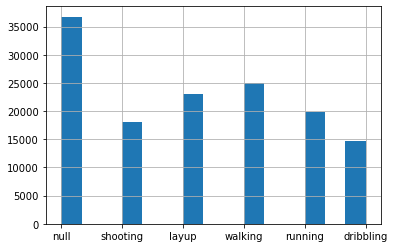

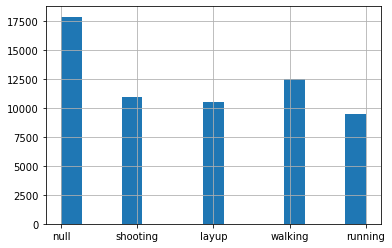

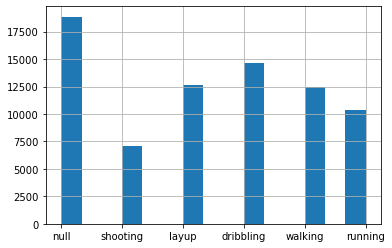

In [2]:
import matplotlib.pyplot as plt

dataframe["Label"].hist(bins=15)
plt.show()

df_subj1["Label"].hist(bins=15)
plt.show()

df_subj2["Label"].hist(bins=15)
plt.show()

Define Sliding window method

In [3]:
def sliding_window_samples(data, samples_per_window, overlap_ratio):
    windows = []
    indices = []
    curr =  0
    win_len = samples_per_window
    if overlap_ratio !=  None :
        overlapping_elements = int((overlap_ratio / 100) * (win_len))
    if overlapping_elements >= win_len:
        print('Number of overlapping elements exceeds window size.')
    while (curr < len(data) - win_len):
         windows.append(data[curr:curr + win_len])
         indices.append([curr, curr + win_len])
         curr = curr + win_len - overlapping_elements
         
         try:
            result_windows = np.array(windows)
            result_indices = np.array(indices)
         except:
             result_windows = np.empty( shape =(len(windows), win_len, data.shape[1]), dtype =object)
             result_indices = np.array(indices)
             for i in range(0, len(windows)):
                result_windows[i] = windows[i]
                result_indices[i] = indices[i]
    return result_windows, result_indices

In [4]:
def metrics(y_test, y_pred, Accuracy, Precision, Recall, f1_score):
    #Import scikit-learn metrics module for accuracy calculation
    from sklearn import metrics
    
    Accuracy = Accuracy + metrics.accuracy_score(y_test, y_pred)
    Precision = Precision + metrics.precision_score(y_test, y_pred, average='weighted')
    Recall = Recall + metrics.recall_score(y_test, y_pred, average='weighted')
    f1_score = f1_score + metrics.f1_score(y_test, y_pred, average='weighted') 
    return Accuracy, Precision, Recall, f1_score

1. Import kNN classifier and train the model
2. Check Metrics

In [5]:
def kNN_model(X_train, y_train, X_test, y_test, Accuracy, Precision, Recall, f1_score):
    #Import kNN model
    from sklearn.neighbors import KNeighborsClassifier

    #Create a kNN Classifier
    model = KNeighborsClassifier(n_neighbors=5)
    # Train the model using the training sets
    model.fit(X_train,y_train)
    #Predict Output
    y_pred = model.predict(X_test)
    
    Accuracy, Precision, Recall, f1_score = metrics(y_test, y_pred, Accuracy, Precision, Recall, f1_score)
    return Accuracy, Precision, Recall, f1_score

1. Import SVM classifier and train the model
2. Check Metrics

In [6]:
def SVM_model(X_train, y_train, X_test, y_test, Accuracy, Precision, Recall, f1_score):
    #Import svm model
    from sklearn import svm

    #Create a svm Classifier
    #clf = svm.SVC(kernel='linear') # Linear Kernel
    clf = svm.SVC(kernel='rbf', C=1, gamma='auto')
    #Train the model using the training sets
    clf.fit(X_train, y_train)
    #Predict the response for test dataset
    y_pred = clf.predict(X_test)
    
    Accuracy, Precision, Recall, f1_score = metrics(y_test, y_pred, Accuracy, Precision, Recall, f1_score)
    return Accuracy, Precision, Recall, f1_score

Per subject validation using Sliding window
1. Set test subject as required
2. Remove unnecessary Columns
3. Converting string labels into numbers using labelencoder
4. Apply sliding window and then split data into train and test sets
5. Reshape the train and test matrices to match with the algorithm input shape

In [7]:
def per_subject_SL(dataframe, model):
    X = dataframe.drop("Label", axis=1)
    X = X.drop("Subject", axis=1)
    y = dataframe["Label"]

    # Import LabelEncoder
    from sklearn import preprocessing
    #creating labelEncoder
    le = preprocessing.LabelEncoder()
    # Converting string labels into numbers.
    y_encoded=le.fit_transform(y)

    X_windows, X_indices = sliding_window_samples(X, 100, 70)
    y_windows, y_indices = sliding_window_samples(y_encoded, 100, 70)
    
    Accuracy = 0
    Precision = 0
    Recall = 0
    f1_score = 0
    print("Model:", model)
    
    for i in range(10):
        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X_windows, y_windows, test_size=0.2)

        X_train = np.reshape(X_train, (X_train.shape[0], -1))
        X_test = np.reshape(X_test, (X_test.shape[0], -1))

        from scipy import stats
        y_train = (stats.mode(y_train, axis=1)).mode
        y_train = np.reshape(y_train, (y_train.shape[0],))
        y_test = (stats.mode(y_test, axis=1)).mode
        y_test = np.reshape(y_test, (y_test.shape[0],))

        Accuracy, Precision, Recall, f1_score = model(X_train, y_train, X_test, y_test, Accuracy, Precision, Recall, f1_score)
    
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:", Accuracy/10)
    # Model Precision: what percentage of positive tuples are labeled as such?
    print("Precision:", Precision/10)
    # Model Recall: what percentage of positive tuples are labelled as such?
    print("Recall:", Recall/10)
    # Model f1_score: weighted average of the precision and recall
    print("f1_score:", f1_score/10)

Cross subject validation using Sliding window
1. Remove data with label 'dribbling' for subject2
2. Select train and test subjects as required
3. Remove unnecessary Columns
4. Converting string labels into numbers using labelencoder
5. Apply sliding window on the train and test sets 
6. Reshape the train and test matrices to match with the algorithm input shape

In [8]:
def cross_subject_SL(train_data, test_data, model):
    X_train = train_data.drop("Label", axis=1)
    X_train = X_train.drop("Subject", axis=1)
    y_train = train_data["Label"]

    X_test = test_data.drop("Label", axis=1)
    X_test = X_test.drop("Subject", axis=1)
    y_test = test_data["Label"]

    # Import LabelEncoder
    from sklearn import preprocessing
    #creating labelEncoder
    le = preprocessing.LabelEncoder()
    # Converting string labels into numbers.
    y_train=le.fit_transform(y_train)
    y_test=le.fit_transform(y_test)

    X_train, X_indices_train = sliding_window_samples(X_train, 100, 70)
    y_train, y_indices_train = sliding_window_samples(y_train, 100, 70)
    X_test, X_indices_test = sliding_window_samples(X_test, 100, 70)
    y_test, y_indices_test = sliding_window_samples(y_test, 100, 70)
  
    Accuracy = 0
    Precision = 0
    Recall = 0
    f1_score = 0   
    print("Model:", model)
    
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))

    from scipy import stats
    y_train = (stats.mode(y_train, axis=1)).mode
    y_train = np.reshape(y_train, (y_train.shape[0],))
    y_test = (stats.mode(y_test, axis=1)).mode
    y_test = np.reshape(y_test, (y_test.shape[0],))

    Accuracy, Precision, Recall, f1_score = model(X_train, y_train, X_test, y_test, Accuracy, Precision, Recall, f1_score)
        
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy:", Accuracy/10)
    # Model Precision: what percentage of positive tuples are labeled as such?
    print("Precision:", Precision/10)
    # Model Recall: what percentage of positive tuples are labelled as such?
    print("Recall:", Recall/10)
    # Model f1_score: weighted average of the precision and recall
    print("f1_score:", f1_score/10)

In [9]:
# Normal and Per subject validations
print("OverallDataset:")
per_subject_SL(dataframe, kNN_model) # Overall dataset -kNN
per_subject_SL(dataframe, SVM_model) # Overall dataset -SVM

print("Subject1:") 
per_subject_SL(df_subj1, kNN_model) # Subject 1 -kNN
per_subject_SL(df_subj1, SVM_model) # Subject 1 -SVM

print("Subject2:")
per_subject_SL(df_subj2, kNN_model) # Subject 2 -kNN
per_subject_SL(df_subj2, SVM_model) # Subject 2 -SVM

# Cross subject validations
print("Subject1:Train, Subject2:Test") 
cross_subject_SL(df_subj1, new_df_subj2, kNN_model) # Subject1:Train -kNN
cross_subject_SL(df_subj1, new_df_subj2, SVM_model) # Subject1:Train -SVM

print("Subject2:Train, Subject1:Test")
cross_subject_SL(new_df_subj2, df_subj1, kNN_model) # Subject2:Train -kNN
cross_subject_SL(new_df_subj2, df_subj1, SVM_model) # Subject2:Train -SVM

OverallDataset:
Model: <function kNN_model at 0x000001AB319671F0>
Accuracy: 0.6869945355191256
Precision: 0.7713833216602487
Recall: 0.6869945355191256
f1_score: 0.6671331989007246
Model: <function SVM_model at 0x000001AB319670D0>
Accuracy: 0.9216393442622952
Precision: 0.923185015660526
Recall: 0.9216393442622952
f1_score: 0.9215620911153379
Subject1:
Model: <function kNN_model at 0x000001AB319671F0>
Accuracy: 0.7127139364303179
Precision: 0.7964390319489529
Recall: 0.7127139364303179
f1_score: 0.6854135255791245
Model: <function SVM_model at 0x000001AB319670D0>
Accuracy: 0.9420537897310514
Precision: 0.9434745573334118
Recall: 0.9420537897310514
f1_score: 0.9420925913143868
Subject2:
Model: <function kNN_model at 0x000001AB319671F0>
Accuracy: 0.7217391304347827
Precision: 0.7919001265469708
Recall: 0.7217391304347827
f1_score: 0.6945262694068577
Model: <function SVM_model at 0x000001AB319670D0>
Accuracy: 0.9051383399209486
Precision: 0.9083191765596196
Recall: 0.9051383399209486
f1_s